In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/Orange3_colab/Orange3/Classification_Distance/house-unscaled.csv')
df.shape

(20495, 93)

In [4]:
#입력 변수로 구성된 data와 target 데이터세트 구성 및 데이터 5:5 분할

data = df.drop(['VALP_B1'], axis = 1)
target = df['VALP_B1']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size = 0.5, random_state = 42
)
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)

X_train shape (10247, 92)
X_test shape (10248, 92)


In [5]:
#라쏘 모델(liblinear를 사용한 기본 모델)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

ls = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 1, random_state = 0)
model = ls.fit(X_train, y_train)

#학습된 Classifier로 테스트 데이터세트를 이용해서 타깃 변수 예측값 생성
pred = model.predict(X_test)

print("Accuracy on traing set: {:.5f}".format(model.score(X_train, y_train)))
print("Accuracy on test set: {:.5f}".format(accuracy_score(y_test, pred)))

Accuracy on traing set: 0.74851
Accuracy on test set: 0.72834


In [11]:
#그리드서치 
#라쏘 모델
ls = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 1, random_state = 0)

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

#StratifiedKFold의 random_state 옵션값을 특정 숫자(예 : 0)로 고정
cross_validation = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
params = {'solver' :['liblinear'], 'C':[0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1]}

#GridSearchCV의 cv=cross_validation 옵션값은 위의 StratifiedKFold의 random_state 옵션값을 적용해 GridSearchCV를 실행할 때마다 항상 동일한 결과가 나오도록 보장
grid_ls = GridSearchCV(
    ls, param_grid=params, scoring = 'accuracy', cv = cross_validation, n_jobs = -1, verbose = 1
)
grid_ls.fit(X_train, y_train)

print("GridSearchCV max accuracy:{:.5f}".format(grid_ls.best_score_))
print("GridSearchCV best parameter:", (grid_ls.best_params_))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV max accuracy:0.74393
GridSearchCV best parameter: {'C': 0.5, 'solver': 'liblinear'}


In [12]:
#데이터세트에 적용
best_clf = grid_ls.best_estimator_
pred = best_clf.predict(X_test)
print("Accuracy on test set:{:.5f}".format(accuracy_score(y_test, pred)))

from sklearn.metrics import roc_auc_score

ROC_AUC = roc_auc_score(y_test, best_clf.predict_proba(X_test)[:, 1])
print("ROC AUC on test set:{:.5f}".format(ROC_AUC))

Accuracy on test set:0.72990
ROC AUC on test set:0.80693


In [13]:
#라쏘 모델은 L1 제약의 특성상 계수들을 0으로 만드는 경향이 있기 때문에 확인해 봐야함
print("Number of feature used:", np.sum(best_clf.coef_ !=0))

Number of feature used: 77


In [14]:
#라쏘 모델의 변수명과 계숫값을 함께 출력

feature_names = list(data.columns)

# 변수 index에 coefficient값을 매칭해 데이터프레임으로 저장

dft = pd.DataFrame(best_clf.coef_.transpose(), index = feature_names, columns = ['coef'])
dft1 = dft.sort_values(by = 'coef', ascending = False)
dft1

,coef
MV_2.0,1.533978
MV_3.0,1.116969
MV_4.0,1.011010
MV_1.0,0.871250
SCH_3,0.826206
...,...
FPARC_0,-0.857552
BATH,-0.868577
BLD_2.0,-1.015059
HHT_2.0,-1.140558


In [15]:
#오즈비 계산
feature_names = list(data.columns)
dft = pd.DataFrame(
    np.exp(best_clf.coef_).transpose(), index = feature_names, columns = ['Odds_ratio'])
dft1 = dft.sort_values(by = 'Odds_ratio', ascending = False)
dft1

,Odds_ratio
MV_2.0,4.636583
MV_3.0,3.055578
MV_4.0,2.748374
MV_1.0,2.389897
SCH_3,2.284635
...,...
FPARC_0,0.424199
BATH,0.419548
BLD_2.0,0.362381
HHT_2.0,0.319640


In [17]:
#오즈비가 1, 즉 계숫값이 0인 변수를 제거
dft2 = dft1[dft1['Odds_ratio'] != 1]
dft2.shape

(77, 1)

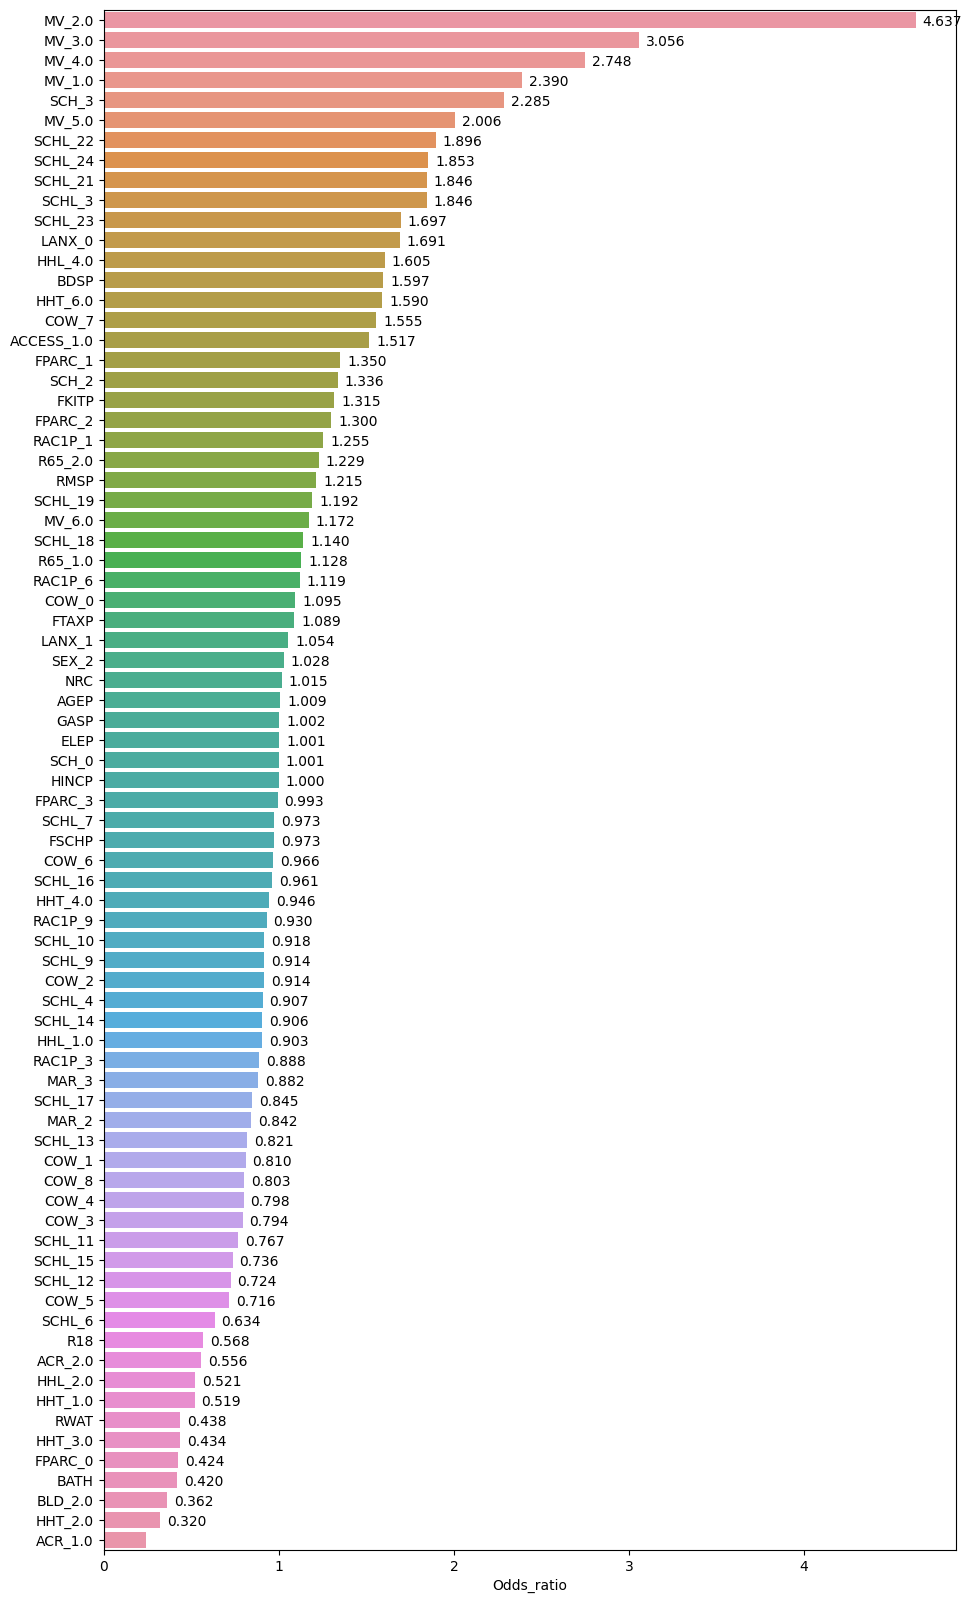

In [18]:
#막대그래프 표현
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(figsize = (11, 20))
ax = sns.barplot(y = dft2.index, x = "Odds_ratio", data = dft2)

for p in ax.patches:
  ax.annotate("%.3f" %p.get_width(), (p.get_x()+p.get_width(),
                                      p.get_y()+1.4), xytext=(5, 10), textcoords = 'offset points')